**Table of contents**<a id='toc0_'></a>    
- [Image classification example](#toc1_)    
- [Pretrained Image classification example - ResNet18](#toc2_)    
- [Pretrained Image classification example - Transformer](#toc3_)    
- [Sequential classification (Unsupported for now)](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# Create dataset and task - tiniest imagenet

In [1]:
import openml
from openml.tasks import OpenMLClassificationTask

import numpy as np
import pandas as pd
import sklearn.datasets
from scipy.sparse import coo_matrix

import openml
from openml.datasets.functions import create_dataset
import os
import requests
import zipfile
import glob

In [2]:
def create_tiny_imagenet():
    dir_name = "datasets"
    os.makedirs(dir_name, exist_ok=True)

    # download the dataset
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    r = requests.get(url, stream=True)

    if not os.path.exists(f"{dir_name}/tiny-imagenet-200.zip"):
        with open(f"{dir_name}/tiny-imagenet-200.zip", "wb") as f:
            f.write(r.content)

        with zipfile.ZipFile(f"{dir_name}/tiny-imagenet-200.zip", 'r') as zip_ref:
            zip_ref.extractall(f"{dir_name}/")
    ## recusively find all the images
    image_paths = glob.glob(f"{dir_name}/tiny-imagenet-200/train/*/*/*.JPEG")
    ## remove the first part of the path
    image_paths = [path.split("/", 1)[-1] for path in image_paths]
    ## create a dataframe with the image path and the label
    label_func = lambda x: x.split("/")[2]
    df = pd.DataFrame(image_paths, columns=["image_path"])
    df["label"] = df["image_path"].apply(label_func)
    ## encode the labels as integers
    df["Class_encoded"] = pd.factorize(df["label"])[0]

    ## encode types
    df["image_path"] = df["image_path"].astype("string")
    df["label"] = df["label"].astype("string")
    df["Class_encoded"] = df["Class_encoded"].astype("int")


    name = "tiny-imagenet-200"
    attribute_names = df.columns
    description = "Tiny ImageNet contains 100000 images of 200 classes (500 for each class) downsized to 64 x 64 colored images. Each class has 500 training images, 50 validation images, and 50 test images. The dataset here just contains links to the images and the labels. The dataset can be downloaded from the official website ![here](http://cs231n.stanford.edu/tiny-imagenet-200.zip). /n Link to the paper - [Tiny ImageNet Classification with CNN](https://cs231n.stanford.edu/reports/2017/pdfs/930.pdf)"
    paper_url = "https://cs231n.stanford.edu/reports/2017/pdfs/930.pdf"
    citation = ("Wu, J., Zhang, Q., & Xu, G. (2017). Tiny imagenet challenge. Technical report.")

    tinyim = create_dataset(
        name = name,
        description = description,
        creator= "Jiayu Wu, Qixiang Zhang, Guoxi Xu",
        contributor = "Jiayu Wu, Qixiang Zhang, Guoxi Xu",
        collection_date = "2017",
        language= "English",
        licence="DbCL v1.0",
        default_target_attribute="Class_encoded",
        attributes="auto",
        data=df,
        citation=citation,
        ignore_attribute=None
    )
    # openml.config.apikey = ''
    tinyim.publish()
    print(f"URL for dataset: {tinyim.openml_url}")

# create_tiny_imagenet()
# https://www.openml.org/d/46338

In [ ]:
def create_tiniest_imagenet():
    dir_name = "datasets"
    os.makedirs(dir_name, exist_ok=True)

    # download the dataset
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    r = requests.get(url, stream=True)

    if not os.path.exists(f"{dir_name}/tiny-imagenet-200.zip"):
        with open(f"{dir_name}/tiny-imagenet-200.zip", "wb") as f:
            f.write(r.content)

        with zipfile.ZipFile(f"{dir_name}/tiny-imagenet-200.zip", 'r') as zip_ref:
            zip_ref.extractall(f"{dir_name}/")
    ## recusively find all the images
    image_paths = glob.glob(f"{dir_name}/tiny-imagenet-200/train/*/*/*.JPEG")
    ## remove the first part of the path
    image_paths = [path.split("/", 1)[-1] for path in image_paths]
    image_paths[-1]
    ## create a dataframe with the image path and the label
    label_func = lambda x: x.split("/")[2]
    df = pd.DataFrame(image_paths, columns=["image_path"])
    df["label"] = df["image_path"].apply(label_func)
    ## encode the labels as integers
    df["Class_encoded"] = pd.factorize(df["label"])[0]

    ## encode types
    df["image_path"] = df["image_path"].astype("string")
    df["label"] = df["label"].astype("string")
    df["Class_encoded"] = df["Class_encoded"].astype("int")

    # keep only first 20 images for each label
    df = df.groupby("label").head(20)


    name = "tiniest-imagenet-200"
    attribute_names = df.columns
    description = "Tiny ImageNet contains 100000 images of 200 classes (500 for each class) downsized to 64 x 64 colored images. !!! This dataset only links to 20 images per class (instead of the usual 500) and is ONLY for quickly testing a framework. !!! Each class has 500 training images, 50 validation images, and 50 test images. The dataset here just contains links to the images and the labels. The dataset can be downloaded from the official website ![here](http://cs231n.stanford.edu/tiny-imagenet-200.zip). /n Link to the paper - [Tiny ImageNet Classification with CNN](https://cs231n.stanford.edu/reports/2017/pdfs/930.pdf)"
    paper_url = "https://cs231n.stanford.edu/reports/2017/pdfs/930.pdf"
    citation = ("Wu, J., Zhang, Q., & Xu, G. (2017). Tiny imagenet challenge. Technical report.")

    tinyim = create_dataset(
        name = name,
        description = description,
        creator= "Jiayu Wu, Qixiang Zhang, Guoxi Xu",
        contributor = "Jiayu Wu, Qixiang Zhang, Guoxi Xu",
        collection_date = "2017",
        language= "English",
        licence="DbCL v1.0",
        default_target_attribute="Class_encoded",
        attributes="auto",
        data=df,
        citation=citation,
        ignore_attribute=None
    )
    tinyim.publish()
    print(f"URL for dataset: {tinyim.openml_url}")

# create_tiniest_imagenet()
# https://www.openml.org/d/46339

URL for dataset: https://www.openml.org/d/46339


In [ ]:
def create_task():
    # openml.config.apikey = 'KEY'
    # Define task parameters
    task_type = openml.tasks.TaskType.SUPERVISED_CLASSIFICATION
    dataset_id = 46339
    evaluation_measure = 'predictive_accuracy'
    target_name = 'Class_encoded'
    class_labels = list(map(str, range(200)))
    cost_matrix = None

    # 'split': <openml.tasks.split.OpenMLSplit object at 0x7efca59476a0>

    # Create the task
    new_task = openml.tasks.create_task(
        task_type=task_type,
        dataset_id=dataset_id, 
        estimation_procedure_id = 1,
        evaluation_measure=evaluation_measure,
        target_name=target_name,
        class_labels=class_labels,
        cost_matrix=cost_matrix
    )
    new_task.publish()
    print(f"URL for task: {new_task.openml_url}")
# create_task()
# https://www.openml.org/t/362127

URL for task: https://www.openml.org/t/362127


# Image classification task

In [16]:
import torch.nn
import torch.optim

import openml_pytorch.config
import openml
import logging
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')

############################################################################
# Enable logging in order to observe the progress while running the example.
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
############################################################################

############################################################################
from openml_pytorch.trainer import OpenMLTrainerModule
from openml_pytorch.trainer import OpenMLDataModule
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
import torchvision

from openml_pytorch.trainer import convert_to_rgb

In [54]:
transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(
            convert_to_rgb
        ),  # Convert PIL Image to RGB if it's not already.
        Resize(
            (64, 64)
        ),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="Class_encoded",
    batch_size = 64,
    transform=transform
)
# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362127)
model = torchvision.models.resnet18(num_classes=200)

trainer = OpenMLTrainerModule(
    data_module=data_module,
    verbose = True,
    epoch_count = 1,
    # optimizer_gen = torch.optim.AdamW
)
openml_pytorch.config.trainer = trainer
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

train: [5.642667341820988, tensor(0.0037, device='mps:0')]
valid: [5.325385538736979, tensor(0.0083, device='mps:0')]
Loss tensor(5.1998, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

train: [5.656022135416666, tensor(0.0040, device='mps:0')]
valid: [5.315435791015625, tensor(0.0056, device='mps:0')]
Loss tensor(5.3225, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

train: [5.625498529128087, tensor(0.0052, device='mps:0')]
valid: [5.440242513020833, tensor(0.0056, device='mps:0')]
Loss tensor(5.6792, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

train: [5.62496925636574, tensor(0.0046, device='mps:0')]
valid: [5.442619832356771, tensor(0.0056, device='mps:0')]
Loss tensor(5.4312, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

train: [5.684549213927469, tensor(0.0037, device='mps:0')]
valid: [5.593141682942709, tensor(0.0056, device='mps:0')]
Loss tensor(5.3203, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

train: [5.655013623649691, tensor(0.0037, device='mps:0')]
valid: [5.354071044921875, tensor(0.0056, device='mps:0')]
Loss tensor(5.3786, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

train: [5.6599470727237655, tensor(0.0043, device='mps:0')]
valid: [5.372332085503472, tensor(0.0056, device='mps:0')]
Loss tensor(5.3802, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

train: [5.690953534915123, tensor(0.0049, device='mps:0')]
valid: [5.358800591362847, tensor(0.0056, device='mps:0')]
Loss tensor(5.4277, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

train: [5.616779996141975, tensor(0.0043, device='mps:0')]
valid: [5.374417453342014, tensor(0.0056, device='mps:0')]
Loss tensor(5.5306, device='mps:0')


DEBUG:openml.config:Requested to create log handlers, but they are already created.
INFO:openml.config:Going to run model ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

train: [5.681832320601852, tensor(0.0046, device='mps:0')]
valid: [5.355416531032986, tensor(0.0056, device='mps:0')]
Loss tensor(5.3964, device='mps:0')


INFO:openml.config:Executed Task 362127 on local Flow with name torch.nn.ResNet.932e4aa09df54bb6.


In [49]:
task = openml.tasks.get_task(362127)

In [51]:
task.get_dataset().get_data()[3]

['image_path', 'label', 'Class_encoded']

In [ ]:
run.publish()

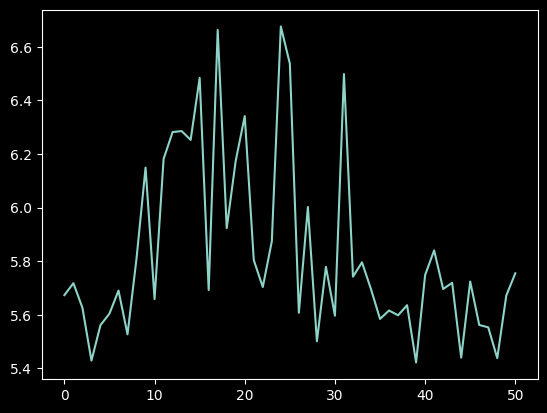

In [6]:
trainer.runner.cbs[1].plot_loss()

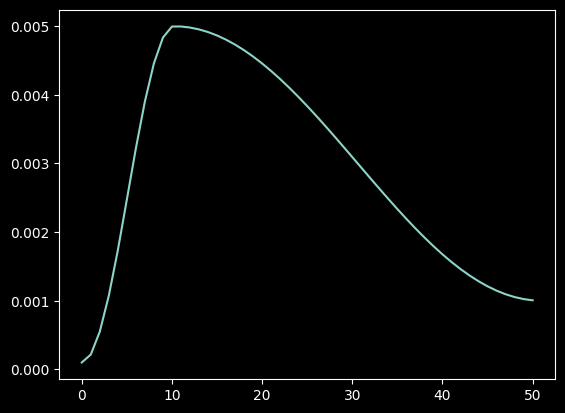

In [5]:
trainer.runner.cbs[1].plot_lr()

In [16]:
trainer.learn.model_classes

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

# Sequential classification (Old example MNIST)

In [ ]:

import torch.nn
import torch.optim

import openml_pytorch.config
import openml
import logging
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')

############################################################################
# Enable logging in order to observe the progress while running the example.
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
############################################################################

In [ ]:
from openml_pytorch.trainer import OpenMLTrainerModule
from openml_pytorch.trainer import OpenMLDataModule

In [ ]:

############################################################################
# Define a sequential network that does the initial image reshaping
# and normalization model.
processing_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 1, 28, 28)),
    torch.nn.BatchNorm2d(num_features=1)
)
############################################################################

############################################################################
# Define a sequential network that does the extracts the features from the
# image.
features_net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
)
############################################################################

############################################################################
# Define a sequential network that flattens the features and compiles the
# results into probabilities for each digit.
results_net = torch.nn.Sequential(
    openml_pytorch.layers.Functional(function=torch.Tensor.reshape,
                                                shape=(-1, 4 * 4 * 64)),
    torch.nn.Linear(in_features=4 * 4 * 64, out_features=256),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=256, out_features=10),
)
############################################################################
# openml.config.apikey = 'key'

############################################################################
# The main network, composed of the above specified networks.
model = torch.nn.Sequential(
    processing_net,
    features_net,
    results_net
)
############################################################################


In [ ]:
data_module = OpenMLDataModule(
    type_of_data="dataframe",
    # file_dir=openml.config.get_cache_directory() + "/datasets/45923/Images/",
    # file_dir=openml.config.get_cache_directory()+'/datasets/44312/PNU_Micro/images/',
    # filename_col="FILE_NAME",
    filename_col="class",
    target_mode="categorical",
)

In [ ]:

trainer = OpenMLTrainerModule(
    data_module=data_module,
    verbose = True,
    epoch_count = 1,
)
openml_pytorch.config.trainer = trainer

In [ ]:
# Download the OpenML task for the mnist 784 dataset.
task = openml.tasks.get_task(3573)

In [ ]:
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

train: [0.32331635113536156, tensor(0.9008, device='mps:0')]
valid: [0.06406866648840526, tensor(0.9811, device='mps:0')]
Loss tensor(0.0628, device='mps:0')


train: [0.38453052662037035, tensor(0.8769, device='mps:0')]
valid: [0.07353694370814733, tensor(0.9784, device='mps:0')]
Loss tensor(0.2696, device='mps:0')


train: [0.32017667686287477, tensor(0.9007, device='mps:0')]
valid: [0.059844534737723214, tensor(0.9830, device='mps:0')]
Loss tensor(0.1902, device='mps:0')


train: [0.3072006930665785, tensor(0.9049, device='mps:0')]
valid: [0.05989732045975942, tensor(0.9832, device='mps:0')]
Loss tensor(0.1913, device='mps:0')


train: [0.35497158151455027, tensor(0.8902, device='mps:0')]
valid: [0.0839210437593006, tensor(0.9757, device='mps:0')]
Loss tensor(0.2628, device='mps:0')


train: [0.36122630070546735, tensor(0.8852, device='mps:0')]
valid: [0.0754026867094494, tensor(0.9811, device='mps:0')]
Loss tensor(0.0035, device='mps:0')


train: [0.31011446621472666, tensor(0.9039, device='mps:0')]
valid: [0.06878100198412698, tensor(0.9811, device='mps:0')]
Loss tensor(0.0127, device='mps:0')


train: [0.3331792190255732, tensor(0.8969, device='mps:0')]
valid: [0.07425410679408483, tensor(0.9798, device='mps:0')]
Loss tensor(0.0351, device='mps:0')


train: [0.3379972373787478, tensor(0.8956, device='mps:0')]
valid: [0.0701195562453497, tensor(0.9797, device='mps:0')]
Loss tensor(0.1058, device='mps:0')


train: [0.35787033592372136, tensor(0.8865, device='mps:0')]
valid: [0.06584922669425844, tensor(0.9830, device='mps:0')]
Loss tensor(0.2519, device='mps:0')


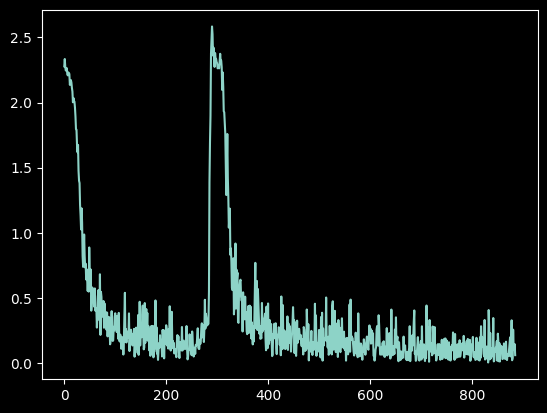

In [ ]:
trainer.runner.cbs[1].plot_loss()

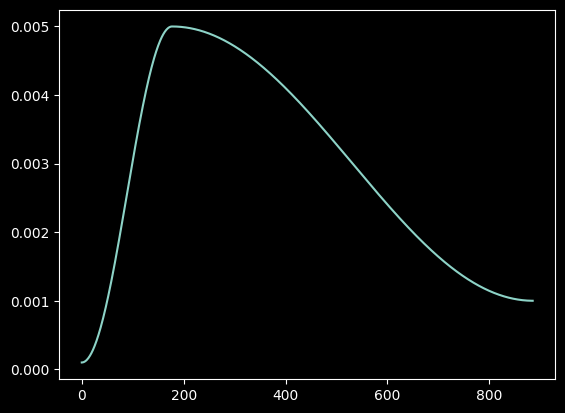

In [ ]:
trainer.runner.cbs[1].plot_lr()

# <a id='toc3_'></a>[Pretrained Image classification example - Transformer](#toc0_)

In [18]:
import torch.nn
import torch.optim

import openml
import openml_pytorch
import openml_pytorch.layers
import openml_pytorch.config
import logging
import warnings
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Lambda
from openml_pytorch.trainer import convert_to_rgb
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore')

############################################################################
# Enable logging in order to observe the progress while running the example.
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
############################################################################

############################################################################
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# openml.config.apikey = 'key'
from openml_pytorch.trainer import OpenMLTrainerModule
from openml_pytorch.trainer import OpenMLDataModule
from openml_pytorch.trainer import Callback

In [19]:
from openml import OpenMLTask
def custom_optimizer_gen(model: torch.nn.Module, task: OpenMLTask) -> torch.optim.Optimizer:
    return torch.optim.Adam(model.fc.parameters())

############################################################################
transform = Compose(
    [
        ToPILImage(),  # Convert tensor to PIL Image to ensure PIL Image operations can be applied.
        Lambda(
            convert_to_rgb
        ),  # Convert PIL Image to RGB if it's not already.
        Resize(
            (64, 64)
        ),  # Resize the image.
        ToTensor(),  # Convert the PIL Image back to a tensor.
    ]
)
data_module = OpenMLDataModule(
    type_of_data="image",
    file_dir="datasets",
    filename_col="image_path",
    target_mode="categorical",
    target_column="Class_encoded",
    batch_size = 64,
    transform=transform
)
# Download the OpenML task for tiniest imagenet
task = openml.tasks.get_task(362127)

trainer = OpenMLTrainerModule(
    data_module=data_module,
    verbose = True,
    epoch_count = 1,
    optimizer = custom_optimizer_gen
)
openml_pytorch.config.trainer = trainer

In [20]:
# Example model. You can do better :)
import torchvision.models as models

# Load the pre-trained ResNet model
model = models.efficientnet_b0(pretrained=True)

# Modify the last fully connected layer to the required number of classes
num_classes = 200
in_features = model.classifier[-1].in_features
# model.fc = nn.Linear(in_features, num_classes)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, num_classes),
)

# Optional: If you're fine-tuning, you may want to freeze the pre-trained layers
# for param in model.parameters():
#     param.requires_grad = False

# # If you want to train the last layer only (the newly added layer)
# for param in model.fc.parameters():
#     param.requires_grad = True

In [21]:
#
# Run the model on the task (requires an API key).m
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

train: [5.488128134645062, tensor(0.0056, device='mps:0')]
valid: [5.460971408420139, tensor(0.0111, device='mps:0')]
Loss tensor(5.2636, device='mps:0')


KeyboardInterrupt: 

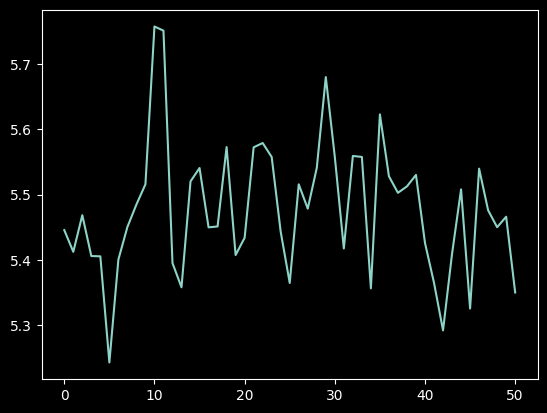

In [43]:
trainer.runner.cbs[1].plot_loss()

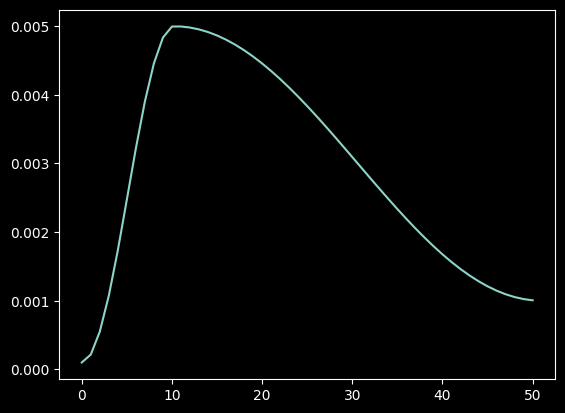

In [44]:
trainer.runner.cbs[1].plot_lr()

# Tabular classification

In [1]:

import torch.nn
import torch.optim

import openml
import openml_pytorch
import openml_pytorch.layers
import openml_pytorch.config
import logging


############################################################################
# Enable logging in order to observe the progress while running the example.
openml.config.logger.setLevel(logging.DEBUG)
openml_pytorch.config.logger.setLevel(logging.DEBUG)
############################################################################

In [2]:
from openml_pytorch.trainer import OpenMLTrainerModule
from openml_pytorch.trainer import OpenMLDataModule
from openml_pytorch.trainer import Callback
import torchvision

In [3]:
# supervised credit-g classification
task = openml.tasks.get_task(31)

/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)


In [4]:
data_module = OpenMLDataModule(
    type_of_data="dataframe",
    target_column="class",
    target_mode="categorical",
)

In [5]:

trainer = OpenMLTrainerModule(
    data_module=data_module,
    verbose = True,
    epoch_count = 5,
)
openml_pytorch.config.trainer = trainer

In [6]:
data = task.get_dataset().get_data()[0]

/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset(self.dataset_id)


In [7]:
class TabularClassificationmodel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(TabularClassificationmodel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, output_size)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [8]:
model = TabularClassificationmodel(20, 2)

In [9]:
run = openml.runs.run_model_on_task(model, task, avoid_duplicate_runs=False)

/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset(self.dataset_id)
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/runs/functions.py:789: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_datas

train: [0.6143298113787615, tensor(0.6988, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset(self.dataset_id)
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/runs/functions.py:789: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_datas

train: [0.6137924382716049, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]


/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset(self.dataset_id)
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/runs/functions.py:789: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_datas

valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


train: [0.6137597731602045, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset(self.dataset_id)
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/runs/functions.py:789: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_datas

train: [0.6136618155020255, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset(self.dataset_id)
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/runs/functions.py:789: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_datas

train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


train: [0.6139356448326582, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset(self.dataset_id)
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/runs/functions.py:789: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_datas

train: [0.6146922923900463, tensor(0.6988, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset(self.dataset_id)
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/runs/functions.py:789: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_datas

train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


train: [0.6138542269483025, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset(self.dataset_id)
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/runs/functions.py:789: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_datas

train: [0.6144284848813657, tensor(0.6988, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset(self.dataset_id)
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/runs/functions.py:789: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_datas

train: [0.6145429069613233, tensor(0.6963, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/task.py:150: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return datasets.get_dataset(self.dataset_id)
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/runs/functions.py:789: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_datas

train: [0.6135488251109182, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]


train: [0.6132615454402971, tensor(0.7000, device='mps:0')]
valid: [0.6132616255018446, tensor(0.7000, device='mps:0')]
Loss tensor(0.7748, device='mps:0')


In [12]:
run.publish()

/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/runs/run.py:650: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  predictions = arff.dumps(self._generate_arff_dict())
/Users/smukherjee/.pyenv/versions/3.11.9/envs/openmlpytorch/lib/python3.11/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)


OpenML Run
Uploader Name...................: None
Metric..........................: None
Local Result - Accuracy (+- STD): 0.7000 +- 0.0000
Run ID..........................: 10595157
Run URL.........................: https://www.openml.org/r/10595157
Task ID.........................: 31
Task Type.......................: None
Task URL........................: https://www.openml.org/t/31
Flow ID.........................: 24263
Flow Name.......................: torch.nn.TabularClassificationmodel.32873d53d0202561
Flow URL........................: https://www.openml.org/f/24263
Setup ID........................: None
Setup String....................: Python_3.11.9. Torch_2.4.1. NumPy_1.26.4. SciPy_1.14.1. TabularClassificationmodel(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
Dataset ID......................: 

In [ ]:
# openml.config.apikey = ''

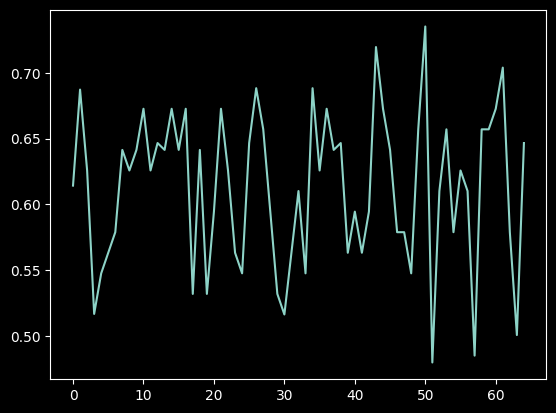

In [10]:
trainer.runner.cbs[1].plot_loss()

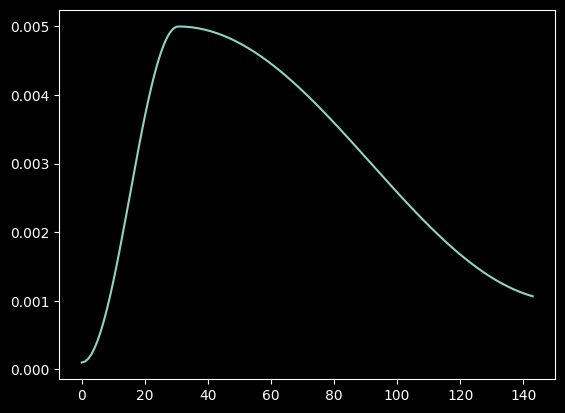

In [34]:
trainer.runner.cbs[1].plot_lr()